# Siamese Network with Triplet Loss

# Importing Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

## Understanding the Approach

This appraoch is taken from the popular [FaceNet](https://arxiv.org/abs/1503.03832) paper.

We have a CNN model called `EmbeddingModel`:

![CNN](assets/CNN.png)

We use three images for each training example:
1. `person1_image1.jpg` (Anchor Example, represented below in green)
2. `person1_image2.jpg` (Positive Example, in blue)
3. `person2_image1.jpg` (Negative Example, in red).

![Embeddings](assets/embeddings.png)


## Siamese Network

All the three images of an example pass through the model, and we get the three Embeddings: One for the Anchor Example, one for the Positive Example, and one for the Negative Example.

![Siamese Network](assets/siamese.png)

The three instances of the `EmbeddingModel` shown above are not different instances. It's the same, shared model instance - i.e. the parameters are shared, and are updated for all the three paths simultaneously.

# Importing the Data

In [2]:
x_train = np.load('../Dataset/X_train.npy')
y_train = np.load('../Dataset/y_train.npy')
x_test = np.load('../Dataset/X_test.npy')
y_test = np.load('../Dataset/y_test.npy')

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(621158, 5)
(621158,)
(155290, 5)
(155290,)


# A Batch of Triplets

The create_batch function constructs a batch of triplets for training a triplet network. It initializes arrays to store anchors, positives, and negatives. For each entry in the batch, it randomly selects an anchor and its label from the training data, then selects a positive example with the same label and a negative example with a different label. These examples are assigned to the corresponding arrays. The function returns a list of the three arrays: anchors, positives, and negatives.

In [4]:
def create_batch(batch_size, x_train, y_train):
    anchors = np.zeros((batch_size, 5))
    positives = np.zeros((batch_size, 5))
    negatives = np.zeros((batch_size, 5))

    for i in range(batch_size):
        index = random.randint(0, len(x_train) - 1)
        anc = x_train[index]
        y = y_train[index]

        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))

        pos = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        neg = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]

        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg

    return [anchors, positives, negatives]

# Embedding Model

The embedding model transforms input data into a 64-dimensional embedding space using a Keras Sequential model. It consists of an input dense layer with 64 units and ReLU activation for initial processing, followed by a dense embedding layer with 64 units and sigmoid activation to produce the final embeddings. This architecture effectively maps input features to a lower-dimensional space, supporting the triplet loss training by distinguishing between similar and dissimilar examples.

In [5]:
emb_dim = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(5,)),
    tf.keras.layers.Dense(emb_dim, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
Total params: 4,544
Trainable params: 4,544
Non-trainable params: 0
_________________________________________________________________


# Siamese Network

The Siamese network processes triplets of inputs (anchor, positive, and negative) by applying a shared embedding model to each, generating 64-dimensional embeddings. It has three input layers, applies the embedding model to each input, and then concatenates the resulting embeddings. This concatenated output is used for training with the triplet loss function.

In [6]:
# Define inputs
in_anc = tf.keras.layers.Input(shape=(5,))
in_pos = tf.keras.layers.Input(shape=(5,))
in_neg = tf.keras.layers.Input(shape=(5,))

# Apply the embedding model to the inputs
em_anc = embedding_model(in_anc)
em_pos = embedding_model(in_pos)
em_neg = embedding_model(in_neg)

# Concatenate the embeddings
out = tf.keras.layers.Concatenate(axis=1)([em_anc, em_pos, em_neg])

# Define the model
net = tf.keras.Model(inputs=[in_anc, in_pos, in_neg], outputs=out)

# Print the model summary
net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64)           4544        ['input_1[0][0]',                
                                                                  'input_2[0][0]',            

# Triplet Loss

A loss function that tries to pull the Embeddings of Anchor and Positive Examples closer, and tries to push the Embeddings of Anchor and Negative Examples away from each other.

Root mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(p_i))^2}{N}}
\end{equation}
$

Root mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(n_i))^2}{N}}
\end{equation}
$

For each example, we want:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training.

We will make it non-trivial by adding a margin (alpha):
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$

The triplet_loss function defines a custom loss for triplet networks by computing the Euclidean distances between anchor-positive and anchor-negative pairs from the model's predictions. It extracts the anchor, positive, and negative embeddings, calculates the squared distances between the anchor and the positive (dp) and between the anchor and the negative (dn), and then computes the triplet loss as max(dp - dn + alpha, 0.0). This loss ensures that the distance between anchor-positive pairs is smaller than that between anchor-negative pairs by at least a margin alpha.

In [7]:
def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]

        # Calculate the Euclidean distance between anchor-positive and anchor-negative
        dp = tf.reduce_mean(tf.square(anc - pos), axis=1)
        dn = tf.reduce_mean(tf.square(anc - neg), axis=1)

        # Compute the triplet loss
        triplet_loss = tf.maximum(dp - dn + alpha, 0.0)
        return triplet_loss

    return loss

# Data Generator

The data_generator function creates an infinite loop that yields batches of triplets for training a triplet network. It calls the create_batch function to generate triplets of anchor, positive, and negative examples, and produces a corresponding label array filled with zeros of shape (batch_size, 3 * emb_dim) to match the model's output dimensions. The generator yields these batches and labels continuously

In [8]:
def data_generator(batch_size, emb_dim):
    while True:
        x = create_batch(batch_size, x_train, y_train)
        y = np.zeros((batch_size, 3 * emb_dim))
        yield x, y

# Model Training

The model is trained by first configuring parameters: a batch size of 1024, 5 epochs, and steps per epoch calculated based on the dataset size. The model is compiled with a triplet loss function, using an Adam optimizer. A PCAPlotter instance is created for visualizing the embeddings. The training is executed with the fit method, utilizing a data generator for batches of triplets and including the PCAPlotter as a callback to monitor embedding changes throughout the training process.

In [9]:
# Define batch_size, epochs, and steps_per_epoch
batch_size = 1024
epochs = 5
steps_per_epoch = int(len(x_train) / batch_size)

# Compile the model
net.compile(loss=triplet_loss(alpha=0.2, emb_dim=emb_dim), optimizer='adam')

In [10]:
# Add EarlyStopping and ModelCheckpoint callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True)

In [11]:
# Train the model and record the history
history = net.fit(
    data_generator(batch_size, emb_dim),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=True,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/5
606/606 [==============================] - 3910s 6s/step - loss: 0.1949
Epoch 2/5
606/606 [==============================] - 3804s 6s/step - loss: 0.1920
Epoch 3/5
606/606 [==============================] - 3905s 6s/step - loss: 0.1916
Epoch 4/5
606/606 [==============================] - 3902s 6s/step - loss: 0.1912
Epoch 5/5
606/606 [==============================] - 3916s 6s/step - loss: 0.1904


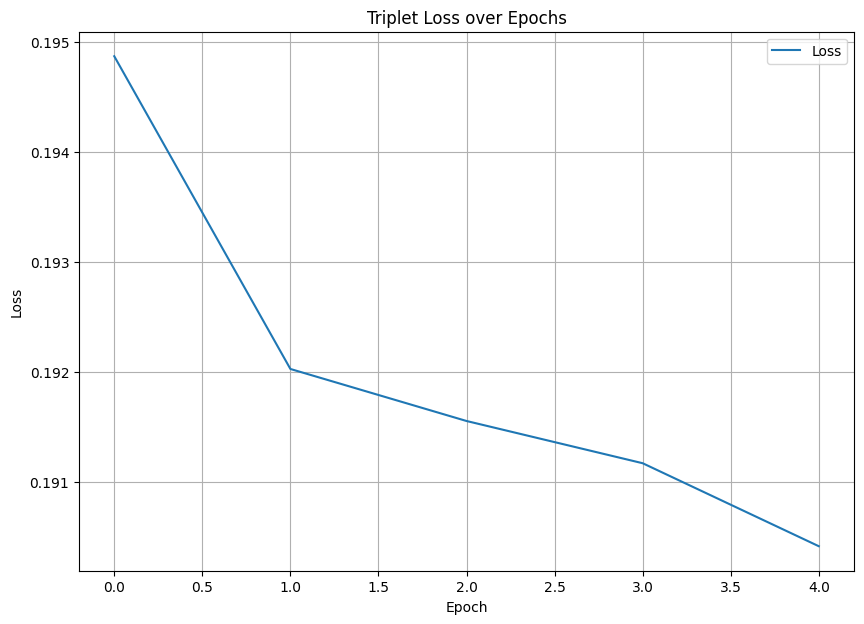

In [12]:
# Plot the loss curve
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Loss')
plt.title('Triplet Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Model Evaluation

4853/4853 [==============================] - 11s 2ms/step
k-NN Accuracy: 0.7853628694700239
Silhouette Score: 0.06530108
Davies-Bouldin Index: 3.5638069253869484


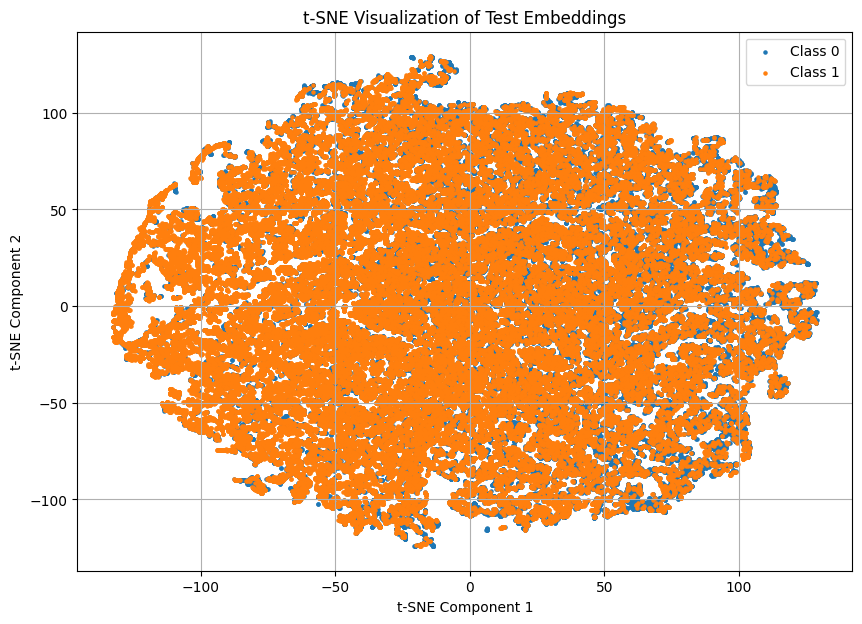

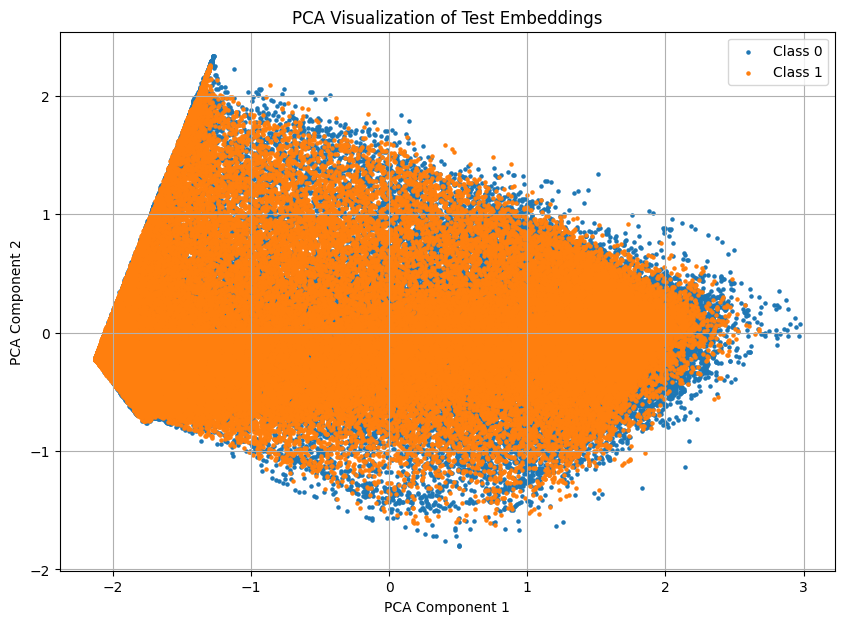

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, silhouette_score, davies_bouldin_score, roc_auc_score, precision_recall_curve
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Generate embeddings for training and test sets
train_embeddings = embedding_model.predict(x_train)
test_embeddings = embedding_model.predict(x_test)

# k-NN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)
y_pred = knn.predict(test_embeddings)
knn_accuracy = accuracy_score(y_test, y_pred)
print('k-NN Accuracy:', knn_accuracy)

# Silhouette Score
sil_score = silhouette_score(test_embeddings, y_test)
print('Silhouette Score:', sil_score)

# Davies-Bouldin Index
db_index = davies_bouldin_score(test_embeddings, y_test)
print('Davies-Bouldin Index:', db_index)

# t-SNE Visualization
tsne = TSNE(n_components=2)
test_embeddings_2d = tsne.fit_transform(test_embeddings)
plt.figure(figsize=(10, 7))
for i in np.unique(y_test):
    mask = y_test == i
    plt.scatter(test_embeddings_2d[mask, 0], test_embeddings_2d[mask, 1], 
                label=f'Class {i}', s=5)
plt.title('t-SNE Visualization of Test Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)
plt.show()

# PCA Visualization
pca = PCA(n_components=2)
test_embeddings_2d = pca.fit_transform(test_embeddings)
plt.figure(figsize=(10, 7))
for i in np.unique(y_test):
    mask = y_test == i
    plt.scatter(test_embeddings_2d[mask, 0], test_embeddings_2d[mask, 1], 
                label=f'Class {i}', s=5)
plt.title('PCA Visualization of Test Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()
